In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df_month = pd.read_parquet('./cleaned_housing_month.parquet')

In [3]:
df_month['target'] = df_month.groupby('area')['average_price'].shift(-1)

In [4]:
df_month = df_month.dropna()

In [6]:
df_month_model = df_month[['average_price', 'houses_sold', 'target']]

X = df_month_model.drop('target', axis=1)
y = df_month_model.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [7]:
# Random forest model
ts_cv = TimeSeriesSplit(n_splits=3)

rf = RandomForestRegressor()
np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=ts_cv))

-6203.722438114615

In [8]:
# Using GridSearchCV to find optimum parameters

parameters = {'n_estimators': range(50,350,50), 'criterion':('mse', 'mae'), 'max_features': ('auto', 'sqrt', 'log2')}
gs = GridSearchCV(rf, parameters, scoring='neg_mean_absolute_error', cv=ts_cv,  n_jobs=-1, verbose=10)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:  4.6min remaining:   10.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ('mse', 'mae'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(50, 350, 50)},
             scoring='neg_mean_absolute_error', verbose=10)

In [9]:
# Storing predictions of the model
ypred_rf = gs.best_estimator_.predict(X_test)

In [10]:
# Testing the prediction

print(mean_absolute_error(y_test, ypred_rf))        # MAE
print((mean_squared_error(y_test, ypred_rf))**0.5)  # RMSE
print(r2_score(y_test, ypred_rf))                   # R2 SCORE

5270.777671581088
9215.640956213569
0.9980215371993332


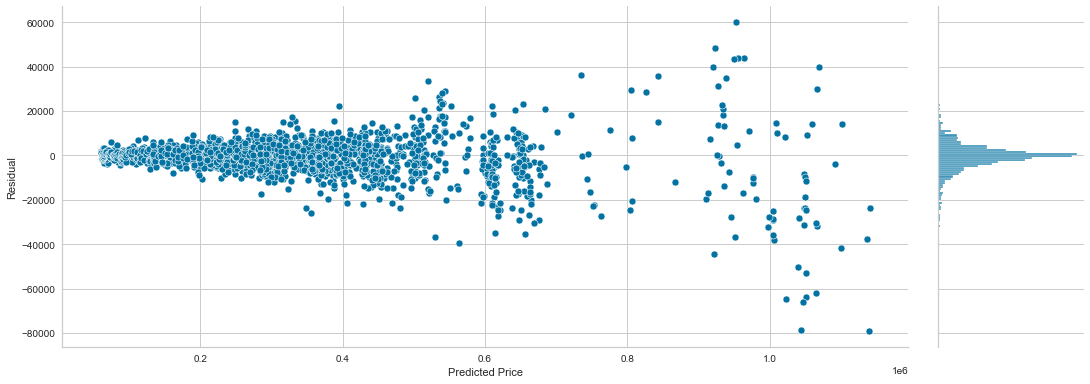

In [11]:
# Residual plots to determine heteroscedasticity and whether constant variance is violated

with sns.axes_style('whitegrid'):
    r = sns.jointplot(x=ypred_rf, y=y_test-ypred_rf, height=12)
    r.set_axis_labels('Predicted Price', 'Residual')
    r.fig.set_figwidth(15)
    r.fig.set_figheight(6)
    r.ax_marg_x._visible=False    